### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer
from enums import EnvironmentType

%run graphUtils.py
%run Visualizer.py # --allows for reloading the particular code
#%run CGConv.py

#### Train the network

In [2]:
from operator import itemgetter

keys = [0, 1, 2, 3]
vals = [np.array([1,2,3]), np.array([3,4,5]), np.array([6,7,8]), np.array([9,10,11])]
dic = dict(zip(keys, vals))
list(itemgetter(*keys)(dic))

[array([1, 2, 3]), array([3, 4, 5]), array([6, 7, 8]), array([ 9, 10, 11])]

In [3]:
n = 15
popsize = 10
generations = 500
batch_size = 8
wrap_around = True
with_global_node = False
env_type = EnvironmentType.Clusters
food_amount = 50
name = 'centered17'
#device = torch.device('mps')
device = torch.device('cpu')
trainer = Evo_Trainer(n, device, batch_size, True, with_global_node, food_amount, env_type, popsize)

2023-03-22 17:11:13,661	INFO worker.py:1528 -- Started a local Ray instance.


[2023-03-22 17:11:17] INFO     <63658> evotorch.core: Instance of `Custom_NEProblem` (id:11290780976) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-03-22 17:11:17] INFO     <63658> evotorch.core: Instance of `Custom_NEProblem` (id:11290780976) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-03-22 17:11:17] INFO     <63658> evotorch.core: Instance of `Custom_NEProblem` (id:11290780976) -- The `device` of the problem is set as cpu
[2023-03-22 17:11:17] INFO     <63658> evotorch.core: Instance of `Custom_NEProblem` (id:11290780976) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-03-22 17:11:17] INFO     <63658> evotorch.core: Instance of `Custom_NEProblem` (id:11290780976) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [4]:
#[trainer.searcher.before_step_hook() for i in range(100)]

In [21]:
trainer.train(generations, name)

         iter : 501
     stepsize : ReadOnlyTensor(0.0323)
pop_best_eval : 53.235225677490234
    mean_eval : 46.365447998046875
  median_eval : 44.92369842529297

         iter : 502
     stepsize : ReadOnlyTensor(0.0323)
pop_best_eval : 51.435054779052734
    mean_eval : 46.84944534301758
  median_eval : 46.07686233520508

         iter : 503
     stepsize : ReadOnlyTensor(0.0323)
pop_best_eval : 54.166255950927734
    mean_eval : 48.221275329589844
  median_eval : 47.145206451416016

         iter : 504
     stepsize : ReadOnlyTensor(0.0323)
pop_best_eval : 77.5804443359375
    mean_eval : 68.97669982910156
  median_eval : 67.76578521728516

         iter : 505
     stepsize : ReadOnlyTensor(0.0323)
pop_best_eval : 54.553321838378906
    mean_eval : 51.499961853027344
  median_eval : 50.95115280151367

         iter : 506
     stepsize : ReadOnlyTensor(0.0323)
pop_best_eval : 61.41196060180664
    mean_eval : 53.6807746887207
  median_eval : 52.918304443359375

         iter : 507
 

In [6]:
network = trainer.get_trained_network()

In [7]:
#trainer.logger_df.from_csv('../logger/' + name + '.csv')
network.load_state_dict(torch.load('../models/' + name + '.pth'))

<All keys matched successfully>

In [8]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'][0])
network = trainer.problem.parameterize_net(trainer.searcher.status['center'][0])
#network = trainer.problem.parameterize_net(trainer.searcher.status['obj0_pop_best'])

In [9]:
#trainer.searcher.status

#### Visualize trained network

In [10]:
v_batch_size= 8
graphs = [generate_organism(n, device, with_global_node, food_amount, env_type).toGraph() for _ in range(v_batch_size)]
loader = DataLoader(graphs, batch_size=v_batch_size)
graph = next(iter(loader))
visualizer = Visualizer(wrap_around, v_batch_size)
network.batch_size = v_batch_size
network(graph, 0)

DataBatch(x=[1720, 5], edge_index=[1, 0], device=[8], subsize=[8], energy=[8], velocity=[8], border_cost=[8], food_reward=[8], dead_cost=[8], visible_food=[8], food_avg_dist=[8], food_avg_degree=[8], food_search_movement=[8], batch=[1720], ptr=[9])

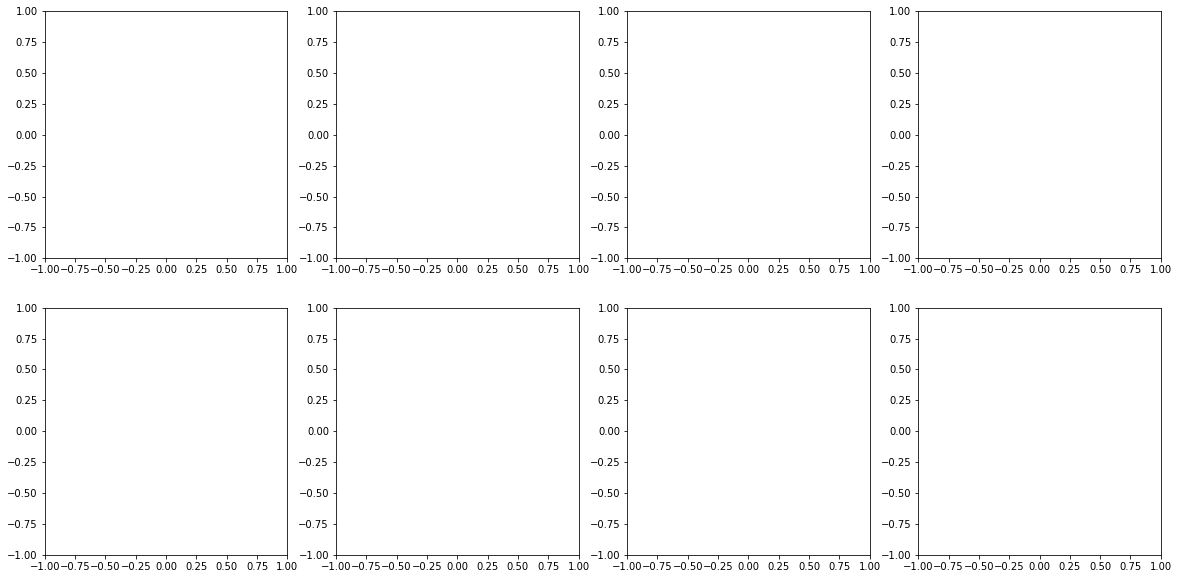

In [11]:
#anim = visualizer.animate_organism(graph, network, food=30, frames=10) #test environment
#visualizer.save_animation_to_gif(anim, name, fps=10, dpi=200) #beautiful

anim = visualizer.animate_organism(graph, network, food=30, frames=200) #visualize model
visualizer.save_animation_to_gif(anim, name, fps=10, dpi=50) #fast

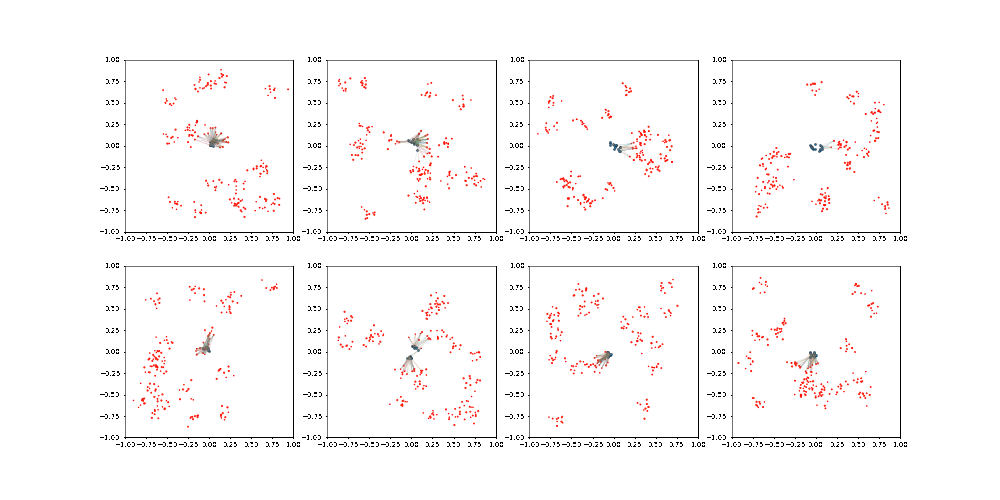

In [12]:
Image('../animation/' + name + '.gif')

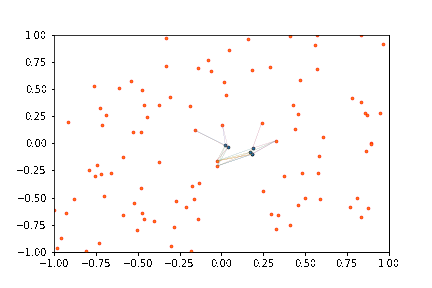

In [13]:
Image('../animation/GATConv1.gif')

In [14]:
#anim.frame_seq = anim.new_saved_frame_seq() 
#IPython.display.HTML(anim.to_jshtml())

In [15]:
print(network)

Conv(
  (conv_layer_food): CustomConvSimple(2, dim=3)
  (conv_layer_cell): CustomConvSimple(2, dim=3)
  (gConvGRU): GConvGRU(
    (conv_x_z): ChebConv(4, 4, K=1, normalization=sym)
    (conv_h_z): ChebConv(4, 4, K=1, normalization=sym)
    (conv_x_r): ChebConv(4, 4, K=1, normalization=sym)
    (conv_h_r): ChebConv(4, 4, K=1, normalization=sym)
    (conv_x_h): ChebConv(4, 4, K=1, normalization=sym)
    (conv_h_h): ChebConv(4, 4, K=1, normalization=sym)
  )
  (mlp_before): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Tanh()
  )
  (conv_layer_cells): CustomConvSimple(2, dim=3)
)


In [16]:
print('GConvGRU: ', network.gConvGRU)
for param in network.gConvGRU.parameters():
  print(param.data)


GConvGRU:  GConvGRU(
  (conv_x_z): ChebConv(4, 4, K=1, normalization=sym)
  (conv_h_z): ChebConv(4, 4, K=1, normalization=sym)
  (conv_x_r): ChebConv(4, 4, K=1, normalization=sym)
  (conv_h_r): ChebConv(4, 4, K=1, normalization=sym)
  (conv_x_h): ChebConv(4, 4, K=1, normalization=sym)
  (conv_h_h): ChebConv(4, 4, K=1, normalization=sym)
)
tensor([-0.0210,  0.1973,  0.0392, -0.1078])
tensor([[ 0.2072,  0.7910, -0.0981,  0.1573],
        [-0.1592, -0.0275,  0.5971, -0.5329],
        [-0.0696, -0.3472,  0.2550, -0.4119],
        [ 0.1364,  0.3661,  0.6802, -0.6998]])
tensor([ 0.2683,  0.1994, -0.1116,  0.2044])
tensor([[ 0.5942,  0.1720, -0.0984, -0.3434],
        [ 0.5779, -0.6654, -0.3337,  0.4441],
        [ 0.0025, -0.0947, -0.4367,  0.1464],
        [ 0.3619,  0.0467, -0.4206, -0.4511]])
tensor([ 0.1284,  0.3644,  0.3396, -0.2256])
tensor([[-1.4048e+00,  1.5294e-01, -2.1277e-01,  1.2325e-01],
        [ 1.7439e-01,  1.2780e-01, -3.8999e-01, -2.5004e-02],
        [ 3.4052e-01, -1.2264e

In [17]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

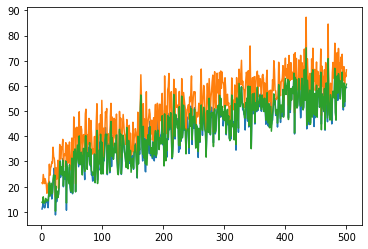

In [18]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
#print(losses)
#plt.plot(losses.stepsize)

plt.plot(losses.median_eval)
plt.plot(losses.pop_best_eval)
plt.plot(losses.mean_eval)
#plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()

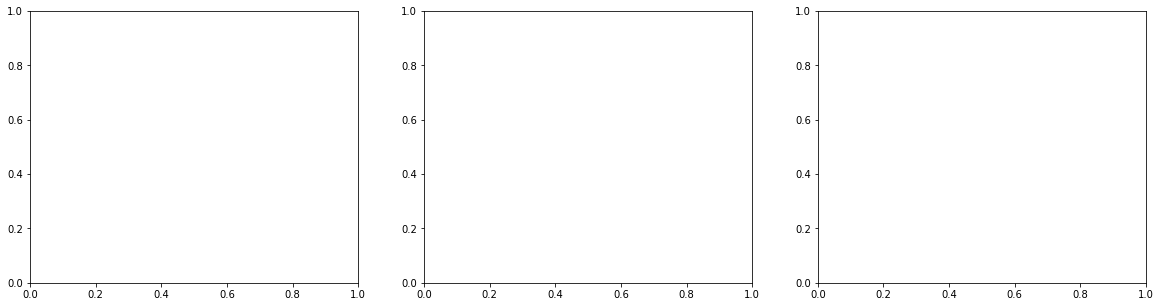

In [19]:
trainer.logger_df
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle('')
plt.show()

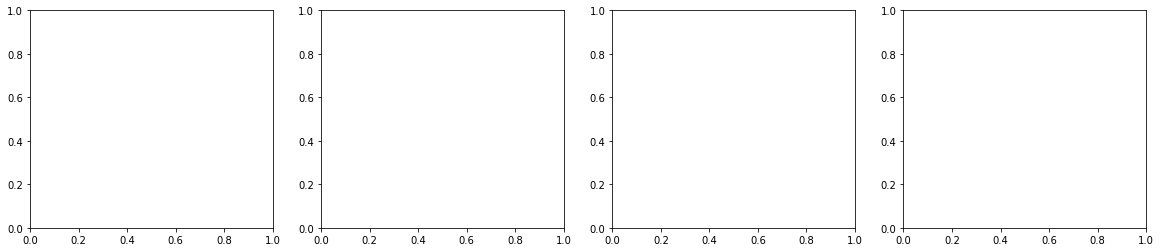

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))